In [30]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
import pandas as pd

class EnhancedProMP:
    def __init__(self, n_basis=15, basis_width_factor=1.0, regularization=1e-12, basis_type='gaussian'):
        """
        Initialize ProMP with tunable parameters
        
        Parameters:
        n_basis: number of basis functions
        basis_width_factor: controls width of basis functions (higher = wider)
        regularization: regularization term for weight fitting
        basis_type: type of basis functions ('gaussian' or 'vonmises')
        """
        self.n_basis = n_basis
        self.basis_width_factor = basis_width_factor
        self.regularization = regularization
        self.basis_type = basis_type
        self.n_dof = 3
        self.weights = None
        self.weights_cov = None
        
    def generate_basis_functions(self, z):
        """
        Generate basis functions with specified type
        """
        c = np.linspace(0, 1, self.n_basis)
        h = self.basis_width_factor/(self.n_basis-1)
        
        phi = np.zeros((len(z), self.n_basis))
        
        if self.basis_type == 'gaussian':
            for i in range(self.n_basis):
                phi[:, i] = np.exp(-0.5 * ((z - c[i])/h)**2)
        elif self.basis_type == 'vonmises':
            # von Mises basis functions (better for periodic movements)
            kappa = 1/(h**2)
            for i in range(self.n_basis):
                phi[:, i] = np.exp(kappa * (np.cos(2*np.pi*(z - c[i])) - 1))
                
        # Normalize basis functions
        sum_phi = phi.sum(axis=1)
        phi = phi / sum_phi[:, None]
        return phi
    
    def compute_basis_function_coverage(self, z):
        """
        Compute and visualize basis function coverage
        """
        phi = self.generate_basis_functions(z)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Plot individual basis functions
        for i in range(self.n_basis):
            ax1.plot(z, phi[:, i])
        ax1.set_title('Individual Basis Functions')
        ax1.set_xlabel('Phase')
        ax1.set_ylabel('Activation')
        
        # Plot sum of basis functions
        ax2.plot(z, phi.sum(axis=1))
        ax2.set_title('Sum of Basis Functions (should be close to 1)')
        ax2.set_xlabel('Phase')
        ax2.set_ylabel('Sum')
        ax2.set_ylim([0.9, 1.1])
        
        plt.tight_layout()
        return fig
    
    def align_trajectories(self, trajectories, n_points=100):
        """
        Time-align trajectories with optional length specification
        """
        aligned_trajs = []
        
        for traj in trajectories:
            old_timestamps = np.linspace(0, 1, len(traj))
            new_timestamps = np.linspace(0, 1, n_points)
            
            aligned_data = {}
            for col in ['EE Position x', 'EE Position y', 'EE Position z']:
                f = interp1d(old_timestamps, traj[col], kind='cubic')
                aligned_data[col] = f(new_timestamps)
            
            aligned_trajs.append(pd.DataFrame(aligned_data))
        
        return aligned_trajs
    
    def fit(self, trajectories, n_points=100):
        """
        Fit ProMP with regularization
        """
        aligned_trajs = self.align_trajectories(trajectories, n_points)
        
        # Generate basis functions
        z = np.linspace(0, 1, n_points)
        phi = self.generate_basis_functions(z)
        
        # Extract positions
        positions = np.array([[traj['EE Position x'].values,
                             traj['EE Position y'].values,
                             traj['EE Position z'].values] 
                            for traj in aligned_trajs])
        
        # Compute weights with regularization
        weights = []
        for demo in positions:
            w = np.zeros((self.n_dof, self.n_basis))
            for d in range(self.n_dof):
                # Add regularization term
                A = phi.T @ phi + self.regularization * np.eye(self.n_basis)
                b = phi.T @ demo[d]
                w[d] = np.linalg.solve(A, b)
            weights.append(w.flatten())
        
        weights = np.array(weights)
        
        # Compute mean and covariance of weights
        self.weights = np.mean(weights, axis=0)
        self.weights_cov = np.cov(weights.T)
        
        return self
    
    def compute_reconstruction_error(self, trajectories):
        """
        Compute reconstruction error for each trajectory
        """
        aligned_trajs = self.align_trajectories(trajectories)
        n_points = len(aligned_trajs[0])
        z = np.linspace(0, 1, n_points)
        phi = self.generate_basis_functions(z)
        
        errors = []
        for traj in aligned_trajs:
            # Original trajectory
            orig = np.array([traj['EE Position x'].values,
                           traj['EE Position y'].values,
                           traj['EE Position z'].values])
            
            # Reconstructed trajectory
            weights = self.weights.reshape(self.n_dof, -1)
            recon = np.zeros((self.n_dof, n_points))
            for d in range(self.n_dof):
                recon[d] = phi @ weights[d]
            
            # Compute RMS error
            error = np.sqrt(np.mean((orig - recon)**2))
            errors.append(error)
            
        return np.mean(errors), np.std(errors)
    
    def plot_training_diagnostics(self, trajectories):
        """
        Plot diagnostic information about the ProMP fitting
        """
        fig = plt.figure(figsize=(15, 10))
        
        # Plot basis function coverage
        ax1 = fig.add_subplot(221)
        z = np.linspace(0, 1, 100)
        phi = self.generate_basis_functions(z)
        ax1.plot(z, phi)
        ax1.set_title('Basis Functions')
        
        # Plot weight distribution
        ax2 = fig.add_subplot(222)
        ax2.hist(self.weights, bins=20)
        ax2.set_title('Weight Distribution')
        
        # Plot covariance matrix
        ax3 = fig.add_subplot(223)
        im = ax3.imshow(self.weights_cov)
        plt.colorbar(im, ax=ax3)
        ax3.set_title('Weight Covariance Matrix')
        
        # Plot reconstruction error distribution
        aligned_trajs = self.align_trajectories(trajectories)
        errors = []
        for traj in aligned_trajs:
            orig = np.array([traj['EE Position x'].values,
                           traj['EE Position y'].values,
                           traj['EE Position z'].values])
            z = np.linspace(0, 1, len(traj))
            phi = self.generate_basis_functions(z)
            weights = self.weights.reshape(self.n_dof, -1)
            recon = np.zeros((self.n_dof, len(traj)))
            for d in range(self.n_dof):
                recon[d] = phi @ weights[d]
            error = np.sqrt(np.mean((orig - recon)**2))
            errors.append(error)
            
        ax4 = fig.add_subplot(224)
        ax4.hist(errors, bins=10)
        ax4.set_title('Reconstruction Error Distribution')
        
        plt.tight_layout()
        return fig
    
    def generate_trajectory(self, n_points=100):
        """
        Generate a new trajectory from the learned distribution
        """
        z = np.linspace(0, 1, n_points)
        phi = self.generate_basis_functions(z)
        
        # Sample weights from distribution
        weights = np.random.multivariate_normal(self.weights, self.weights_cov)
        weights = weights.reshape(self.n_dof, -1)
        
        # Generate trajectory
        trajectory = np.zeros((self.n_dof, n_points))
        for d in range(self.n_dof):
            trajectory[d] = phi @ weights[d]
            
        return trajectory
    
    def plot_distribution(self, trajectories, n_samples=10):
        """
        Plot original trajectories and distribution
        """
        fig = plt.figure(figsize=(15, 5))
        titles = ['X Position', 'Y Position', 'Z Position']
        
        # Align trajectories for plotting
        aligned_trajs = self.align_trajectories(trajectories)
        n_points = len(aligned_trajs[0])
        t = np.linspace(0, 1, n_points)
        
        for d in range(self.n_dof):
            ax = fig.add_subplot(1, 3, d+1)
            
            # Plot original trajectories
            for traj in aligned_trajs:
                pos = traj[f'EE Position {"xyz"[d]}'].values
                ax.plot(t, pos, 'k-', alpha=0.2)
            
            # Generate and plot samples from distribution
            for _ in range(n_samples):
                traj = self.generate_trajectory(n_points)
                ax.plot(t, traj[d], 'r-', alpha=0.1)
            
            ax.set_title(titles[d])
            ax.set_xlabel('Phase')
            ax.set_ylabel('Position')
        
        plt.tight_layout()
        return fig

def tune_promp(trajectories, n_basis_range=[10, 15, 20, 25], 
               width_factors=[0.5, 1.0, 1.5, 2.0],
               regularization_values=[1e-12, 1e-8, 1e-4]):
    """
    Perform grid search over ProMP parameters
    """
    best_error = float('inf')
    best_params = None
    results = []
    
    for n_basis in n_basis_range:
        for width in width_factors:
            for reg in regularization_values:
                promp = EnhancedProMP(n_basis=n_basis, 
                                    basis_width_factor=width,
                                    regularization=reg)
                promp.fit(trajectories)
                mean_error, std_error = promp.compute_reconstruction_error(trajectories)
                
                results.append({
                    'n_basis': n_basis,
                    'width_factor': width,
                    'regularization': reg,
                    'mean_error': mean_error,
                    'std_error': std_error
                })
                
                if mean_error < best_error:
                    best_error = mean_error
                    best_params = (n_basis, width, reg)
    
    return pd.DataFrame(results), best_params

class TrajectoryGMM:
    def __init__(self, n_components=3, covariance_type='full', random_state=42):
        """
        Initialize GMM model for trajectory modeling
        
        Parameters:
        n_components: number of Gaussian components
        covariance_type: type of covariance parameters ('full', 'tied', 'diag', 'spherical')
        random_state: random state for reproducibility
        """
        self.n_components = n_components
        self.gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            random_state=random_state
        )
        self.scaler = StandardScaler()
        self.n_dof = 3  # Assuming 3D trajectories
        
    def prepare_data(self, trajectories):
        """
        Prepare trajectory data for GMM training
        """
        # Stack all trajectories into a single matrix
        data = []
        for traj in trajectories:
            positions = np.vstack([
                traj['EE Position x'].values,
                traj['EE Position y'].values,
                traj['EE Position z'].values
            ]).T
            data.append(positions)
        
        # Combine all trajectories
        X = np.vstack(data)
        
        # Scale the data
        X_scaled = self.scaler.fit_transform(X)
        return X_scaled
        
    def fit(self, trajectories):
        """
        Fit GMM to trajectory data
        """
        X_scaled = self.prepare_data(trajectories)
        self.gmm.fit(X_scaled)
        return self
        
    def sample_trajectories(self, n_samples=1, n_points=100):
        """
        Generate new trajectories from the learned GMM
        """
        # Sample from GMM
        X_samples_scaled = self.gmm.sample(n_samples * n_points)[0]
        
        # Inverse transform the samples
        X_samples = self.scaler.inverse_transform(X_samples_scaled)
        
        # Reshape into separate trajectories
        trajectories = []
        for i in range(n_samples):
            start_idx = i * n_points
            end_idx = (i + 1) * n_points
            traj = X_samples[start_idx:end_idx]
            trajectories.append(traj)
            
        return trajectories
    
    def plot_components(self, trajectories, ax=None):
        """
        Visualize GMM components and original data
        """
        if ax is None:
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(111, projection='3d')
        
        # Plot original trajectories
        for traj in trajectories:
            ax.plot(traj['EE Position x'], 
                   traj['EE Position y'],
                   traj['EE Position z'],
                   'k-', alpha=0.2)
        
        # Plot GMM components
        X_scaled = self.prepare_data(trajectories)
        X = self.scaler.inverse_transform(X_scaled)
        
        # Plot the means of the components
        means = self.scaler.inverse_transform(self.gmm.means_)
        ax.scatter(means[:, 0], means[:, 1], means[:, 2],
                  c='r', marker='x', s=100, label='GMM Centers')
        
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_zlabel('Z Position')
        ax.legend()
        
        return ax

class EnhancedProMPWithGMM(EnhancedProMP):
    """
    Extended ProMP class that incorporates GMM modeling
    """
    def __init__(self, n_basis=15, basis_width_factor=1.0, regularization=1e-12,
                 basis_type='gaussian', n_gmm_components=3):
        super().__init__(n_basis, basis_width_factor, regularization, basis_type)
        self.gmm_model = TrajectoryGMM(n_components=n_gmm_components)
        
    def fit(self, trajectories, n_points=100):
        """
        Fit both ProMP and GMM models
        """
        # Fit ProMP
        super().fit(trajectories, n_points)
        
        # Fit GMM on aligned trajectories
        aligned_trajs = self.align_trajectories(trajectories, n_points)
        self.gmm_model.fit(aligned_trajs)
        
        return self
    
    def generate_hybrid_trajectory(self, n_points=100, blend_factor=0.5):
        """
        Generate trajectory using both ProMP and GMM models
        
        Parameters:
        blend_factor: Weight between ProMP (0) and GMM (1) predictions
        """
        # Generate trajectory from ProMP
        promp_traj = self.generate_trajectory(n_points)
        
        # Generate trajectory from GMM
        gmm_traj = self.gmm_model.sample_trajectories(n_samples=1, n_points=n_points)[0]
        
        # Blend trajectories
        blended_traj = (1 - blend_factor) * promp_traj + blend_factor * gmm_traj.T
        
        return blended_traj
    
    def plot_comparison(self, trajectories, n_samples=5):
        """
        Plot comparison of ProMP and GMM generated trajectories
        """
        fig = plt.figure(figsize=(15, 5))
        
        # Plot original trajectories
        ax1 = fig.add_subplot(131, projection='3d')
        for traj in trajectories:
            ax1.plot(traj['EE Position x'],
                    traj['EE Position y'],
                    traj['EE Position z'],
                    'k-', alpha=0.2)
        ax1.set_title('Original Trajectories')
        
        # Plot ProMP samples
        ax2 = fig.add_subplot(132, projection='3d')
        for _ in range(n_samples):
            traj = self.generate_trajectory(100)
            ax2.plot(traj[0], traj[1], traj[2], 'r-', alpha=0.5)
        ax2.set_title('ProMP Samples')
        
        # Plot GMM samples
        ax3 = fig.add_subplot(133, projection='3d')
        gmm_trajs = self.gmm_model.sample_trajectories(n_samples=n_samples)
        for traj in gmm_trajs:
            ax3.plot(traj[:, 0], traj[:, 1], traj[:, 2], 'b-', alpha=0.5)
        ax3.set_title('GMM Samples')
        
        for ax in [ax1, ax2, ax3]:
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
        
        plt.tight_layout()
        return fig

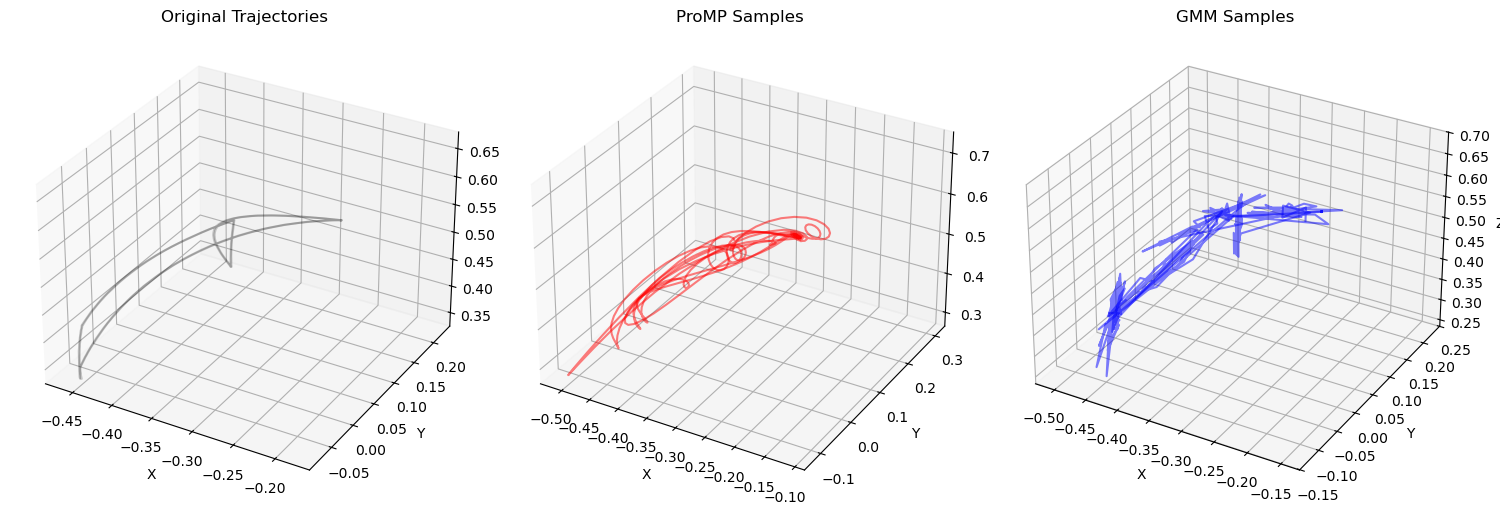

In [48]:
file_paths = ['Kinesthetic_teaching_take_1.csv',
                # 'Kinesthetic_teaching_take_2.csv',
                'Kinesthetic_teaching_take_3.csv', 
                # 'Kinesthetic_teaching_take_4.csv', 
                # 'Kinesthetic_teaching_take_5.csv', 
            ]

trajectories = [pd.read_csv(path) for path in file_paths]

# Initialize the hybrid model
hybrid_model = EnhancedProMPWithGMM(
    n_basis=21,
    basis_width_factor=2.5,
    regularization=1e-12,
    n_gmm_components=7
)

# Fit both models
hybrid_model.fit(trajectories)

# Generate and visualize trajectories
comparison_plot = hybrid_model.plot_comparison(trajectories, n_samples=5)

# Generate a hybrid trajectory (blend ProMP and GMM)
hybrid_traj = hybrid_model.generate_hybrid_trajectory(blend_factor=0.3)

In [52]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

class MultiDimensionalDMP:
    def __init__(self, n_rbf=100, alpha_y=60, beta_y=60/4.0, alpha_x=1.0, cs_runtime=1.0):
        """
        Initialize Multi-dimensional DMP with obstacle avoidance
        
        Parameters:
        n_rbf: number of radial basis functions
        alpha_y: spring-damper constant
        beta_y: spring constant
        alpha_x: decay constant for phase variable
        cs_runtime: runtime of canonical system
        """
        self.n_rbf = n_rbf
        self.alpha_y = alpha_y
        self.beta_y = beta_y
        self.alpha_x = alpha_x
        self.cs_runtime = cs_runtime
        self.x0 = 1.0
        self.tau_t = 1.0
        
        # Initialize separate DMP parameters for each dimension
        self.dmp_params = {}
        
    def _generate_rbf_centers(self, time_steps):
        """Generate centers for radial basis functions"""
        t_centers = np.linspace(0, self.cs_runtime, self.n_rbf)
        t_track = np.linspace(0, self.cs_runtime, time_steps)
        x_track = np.zeros(time_steps)
        
        tmp_x = self.x0
        for i in range(time_steps):
            x_track[i] = tmp_x
            dx = -self.alpha_x * tmp_x * self.dt
            tmp_x = tmp_x + self.tau_t * dx
            
        psi_centers = np.zeros(self.n_rbf)
        for n in range(len(t_centers)):
            for i, t_track_value in enumerate(t_track):
                if abs(t_centers[n] - t_track_value) <= self.dt:
                    psi_centers[n] = x_track[i]
                    
        return psi_centers

    def _prepare_trajectory_data(self, trajectory):
        """
        Convert input trajectory to numpy array format
        """
        if isinstance(trajectory, pd.DataFrame):
            # Extract position columns
            pos_cols = [col for col in trajectory.columns if 'Position' in col]
            if not pos_cols:
                raise ValueError("DataFrame must contain columns with 'Position' in their names")
            trajectory_data = trajectory[pos_cols].values
        elif isinstance(trajectory, np.ndarray):
            trajectory_data = trajectory
        else:
            raise ValueError("Trajectory must be either a pandas DataFrame or numpy array")
        
        return trajectory_data
        
    def fit(self, trajectory):
        """
        Fit DMP to multi-dimensional trajectory
        
        Parameters:
        trajectory: pandas DataFrame with position columns or numpy array of shape (n_points, n_dims)
        """
        # Convert input to appropriate format
        trajectory_data = self._prepare_trajectory_data(trajectory)
        
        self.n_dims = trajectory_data.shape[1]
        self.data_len = trajectory_data.shape[0]
        self.dt = self.cs_runtime / self.data_len
        self.time_steps = round(self.cs_runtime / self.dt)
        
        # Generate RBF centers (shared across dimensions)
        psi_centers = self._generate_rbf_centers(self.time_steps)
        psi_h = np.ones(self.n_rbf) * self.n_rbf ** 1.5 / psi_centers / self.alpha_x
        
        # Train each dimension separately
        for dim in range(self.n_dims):
            y_demo = trajectory_data[:, dim]
            
            # Interpolate demonstration to desired time steps
            x = np.linspace(0, self.cs_runtime, len(y_demo))
            y = np.zeros(self.time_steps)
            y_tmp = interp1d(x, y_demo)
            for k in range(self.time_steps):
                y[k] = y_tmp(k * self.dt)
            
            # Calculate velocities and accelerations
            dy = np.gradient(y) / self.dt
            ddy = np.gradient(dy) / self.dt
            
            # Generate canonical system trajectory
            x_track = np.zeros(self.time_steps)
            self_x = 1.0
            for i in range(self.time_steps):
                x_track[i] = self_x
                dx = -self.alpha_x * self_x * self.dt
                self_x = self_x + self.tau_t * dx
            
            # Calculate target forcing term
            g = y_demo[-1]
            y0 = y_demo[0]
            f_target = ddy - self.alpha_y * (self.beta_y * (g - y) - dy)
            
            # Calculate scaling term
            s = x_track * (g - y0)
            
            # Calculate basis functions
            phi = np.zeros((self.n_rbf, len(y)))
            for i in range(self.n_rbf):
                phi[i] = np.exp(-psi_h[i] * (x_track - psi_centers[i])**2)
            
            # Calculate weights
            w = np.zeros(self.n_rbf)
            epsilon = 1e-6
            for i in range(self.n_rbf):
                frac1 = np.dot(s.T, np.dot(np.diag(phi[i]), f_target))
                frac2 = np.dot(s.T, np.dot(np.diag(phi[i]), s))
                w[i] = frac1 / (frac2 + epsilon)
            
            # Store parameters for this dimension
            self.dmp_params[dim] = {
                'w': w,
                'psi_centers': psi_centers,
                'psi_h': psi_h,
                'y0': y0,
                'g': g
            }
            
        return self
    
    # def _compute_obstacle_force(self, y, dy, obstacles):
    #     """
    #     Compute repulsive force from obstacles
        
    #     Parameters:
    #     y: current position (n_dims)
    #     dy: current velocity (n_dims)
    #     obstacles: list of dictionaries with 'position' and 'radius' keys
    #     """
    #     force = np.zeros(self.n_dims)
        
    #     for obstacle in obstacles:
    #         # Vector from current position to obstacle
    #         obs_vec = obstacle['position'] - y
    #         obs_dist = np.linalg.norm(obs_vec)
            
    #         if obs_dist < obstacle['radius'] * 2:  # Only consider nearby obstacles
    #             # Compute angle between velocity and obstacle vector
    #             vel_norm = np.linalg.norm(dy)
    #             if vel_norm > 0:
    #                 theta = np.arccos(np.dot(obs_vec, dy) / (obs_dist * vel_norm))
                    
    #                 # Compute repulsive force
    #                 magnitude = 100.0 * np.exp(-obs_dist/obstacle['radius'])  # Adjustable strength
    #                 # Force perpendicular to velocity
    #                 force += magnitude * np.cross(np.cross(dy, obs_vec), dy)
                    
    #     return force
    
    def _compute_obstacle_force(self, y, dy, obstacles):
        """
        Compute repulsive force from obstacles
        
        Parameters:
        y: current position (n_dims)
        dy: current velocity (n_dims)
        obstacles: list of dictionaries with 'position' and 'radius' keys
        """
        force = np.zeros(self.n_dims)
        
        for obstacle in obstacles:
            # Ensure obstacle position matches trajectory dimensions
            obs_pos = obstacle['position'][:self.n_dims]  # Take only the first n_dims components
            
            # Vector from current position to obstacle
            obs_vec = obs_pos - y
            obs_dist = np.linalg.norm(obs_vec)
            
            if obs_dist < obstacle['radius'] * 2:  # Only consider nearby obstacles
                # Compute angle between velocity and obstacle vector
                vel_norm = np.linalg.norm(dy)
                if vel_norm > 0:
                    theta = np.arccos(np.dot(obs_vec, dy) / (obs_dist * vel_norm))
                    
                    # Compute repulsive force
                    magnitude = 100.0 * np.exp(-obs_dist/obstacle['radius'])  # Adjustable strength
                    
                    # For 2D case
                    if self.n_dims == 2:
                        # Rotate velocity vector by 90 degrees to get perpendicular direction
                        perp_dy = np.array([-dy[1], dy[0]])
                        force += magnitude * np.sign(np.dot(perp_dy, obs_vec)) * perp_dy / np.linalg.norm(perp_dy)
                    # For 3D case
                    else:
                        # Force perpendicular to velocity
                        force += magnitude * np.cross(np.cross(dy, obs_vec), dy)
                    
        return force
    
    def generate_trajectory(self, start=None, goal=None, tau=1.0, obstacles=None):
        """
        Generate new trajectory with obstacle avoidance
        
        Parameters:
        start: starting position (n_dims)
        goal: target position (n_dims)
        tau: temporal scaling factor
        obstacles: list of dictionaries with 'position' and 'radius' keys
        """
        if obstacles is None:
            obstacles = []
            
        if start is None:
            start = np.array([self.dmp_params[d]['y0'] for d in range(self.n_dims)])
            
        if goal is None:
            goal = np.array([self.dmp_params[d]['g'] for d in range(self.n_dims)])
            
        # Initialize state variables
        time_steps = round(self.time_steps / tau)
        x = self.x0
        y = start.copy()
        dy = np.zeros(self.n_dims)
        
        # Storage for trajectory
        trajectory = np.zeros((time_steps, self.n_dims))
        
        for t in range(time_steps):
            # Update canonical system
            dx = -self.alpha_x * x * self.dt
            x += tau * dx
            
            # Compute forcing term for each dimension
            f = np.zeros(self.n_dims)
            for dim in range(self.n_dims):
                params = self.dmp_params[dim]
                psi = np.exp(-params['psi_h'] * (x - params['psi_centers'])**2)
                f[dim] = np.sum(psi * params['w']) * x * (goal[dim] - start[dim]) / np.sum(psi)
            
            # Add obstacle avoidance force
            if obstacles:
                f += self._compute_obstacle_force(y, dy, obstacles)
            
            # Update system
            for dim in range(self.n_dims):
                ddy = self.alpha_y * (self.beta_y * (goal[dim] - y[dim]) - dy[dim]) + f[dim]
                dy[dim] += tau * ddy * self.dt
                y[dim] += tau * dy[dim] * self.dt
            
            trajectory[t] = y.copy()
            
        return trajectory
    
    def plot_trajectory(self, trajectory, obstacles=None):
        """Plot the generated trajectory with obstacles"""
        if self.n_dims == 3:
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 'b-')
            
            if obstacles:
                for obs in obstacles:
                    # Create sphere
                    u = np.linspace(0, 2 * np.pi, 20)
                    v = np.linspace(0, np.pi, 20)
                    x = obs['radius'] * np.outer(np.cos(u), np.sin(v)) + obs['position'][0]
                    y = obs['radius'] * np.outer(np.sin(u), np.sin(v)) + obs['position'][1]
                    z = obs['radius'] * np.outer(np.ones(np.size(u)), np.cos(v)) + obs['position'][2]
                    ax.plot_surface(x, y, z, color='r', alpha=0.3)
            
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            
        elif self.n_dims == 2:
            plt.figure(figsize=(10, 8))
            plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-')
            
            if obstacles:
                for obs in obstacles:
                    circle = plt.Circle(obs['position'][:2], obs['radius'], color='r', alpha=0.3)
                    plt.gca().add_artist(circle)
            
            plt.axis('equal')
            plt.xlabel('X')
            plt.ylabel('Y')
            
        plt.grid(True)
        plt.show()
        
# Create and fit DMP to a demonstration trajectory
dmp = MultiDimensionalDMP(n_rbf=50)
dmp.fit(trajectories[0])  # Works with either DataFrame or numpy array

# Get start and goal positions from the trajectory
demo_traj = dmp._prepare_trajectory_data(trajectories[0])
start_pos = demo_traj[0]  # First point
goal_pos = demo_traj[-1]  # Last point

# Define some obstacles
obstacles = [
    {
        'position': np.array([0.5, 0.5, 0.5]),
        'radius': 0.2
    },
    {
        'position': np.array([-0.3, 0.4, 0.3]),
        'radius': 0.15
    }
]

# Generate new trajectory
new_traj = dmp.generate_trajectory(
    start=start_pos,
    goal=goal_pos,
    obstacles=obstacles
)

# Visualize the result
dmp.plot_trajectory(new_traj, obstacles=obstacles)

ValueError: operands could not be broadcast together with shapes (3,) (5,) 